In [95]:
import numpy as np
import scipy
from scipy.special import erfc
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
import keras.backend as K
import matplotlib.pyplot as plt

In [96]:
# Encoder Parameters
k = 4
M = 2**k
n = 2
beta = 0.1
SNR = 5


# Channel Parameters
EbNo = 10.0**(SNR/10.0)
noise_std = np.sqrt(1/(2*EbNo))

In [97]:
# generating training data of size N
N = 32000
label = np.random.randint(M,size=N)

#creating one-hot encoded vector
train_data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    train_data.append(temp)
train_data = np.array(train_data)

In [98]:
# generating validation data of size N_val
N_val = 15000
val_label = np.random.randint(M,size=N_val)

#creating one-hot encoded vector
val_data = []
for i in val_label:
    temp = np.zeros(M)
    temp[i] = 1
    val_data.append(temp)
val_data = np.array(val_data)

In [99]:
# generating test data of size N_test
N_test = 50000
test_label = np.random.randint(M,size=N_test)

#creating one-hot encoded vector
test_data = []
for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
test_data = np.array(test_data)

In [100]:
def nonlin_Gaussian(x,noise_std1):
    noise = np.zeros(x.shape) 
    for i in range(len(x)):
        nois = np.random.randn(1,2) # complex Gaussian RV
        var = 0
        absol = np.sqrt(np.sum(np.square(x[i])))
        var = beta*np.square(absol)+np.square(noise_std1)
        noi = np.sqrt(var)*nois
        noise[i] = (noi)
    return noise 

In [101]:
# Defining Autoencoder

# Transmitter Layers 
input_signal = Input(shape=[M,])
encoded = Dense(M, activation='relu')(input_signal)
encoded = Dense(n, activation='linear')(encoded)

# Normalization Layer (Fixed Energy Constraint)
#encoded = Lambda(lambda x: K.l2_normalize(x,axis=-1)*np.sqrt(n))(encoded) 

# Normalization Layer (Average Power Normalization)
encoded = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded)

# Non Linear Gaussian Channel Layer
var = Lambda(lambda x: beta*K.square(K.sqrt(K.sum(K.square(x),axis = 1, keepdims = True)))+K.square(tf.cast(noise_std, tf.float32)))(encoded)
noised  = Lambda(lambda x: x + K.sqrt(var)*K.random_normal(shape=K.shape(x), mean=0., stddev=1.))(encoded)

# Receiver Layers
decoded = Dense(M, activation='relu')(noised)
decoded = Dense(M, activation='softmax')(decoded)

autoencoder = Model(input_signal, decoded)
print(autoencoder.summary())

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 34        
_________________________________________________________________
lambda_25 (Lambda)           (None, 2)                 0         
_________________________________________________________________
lambda_27 (Lambda)           (None, 2)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_36 (Dense)             (None, 16)                272

In [102]:
#sgd = SGD(lr = 0.02)
adam = Adam(lr = 0.001)
autoencoder.compile(optimizer = adam, loss = 'categorical_crossentropy')
hist = autoencoder.fit(train_data, train_data,
                epochs = 200, 
                batch_size = 1024, 
                validation_data = (val_data,val_data)
               )

Train on 32000 samples, validate on 15000 samples
Epoch 1/200
32000/32000 [==============================] - 0s 11us/step - loss: 2.7052 - val_loss: 2.5758
Epoch 2/200
32000/32000 [==============================] - 0s 4us/step - loss: 2.4915 - val_loss: 2.4072
Epoch 3/200
32000/32000 [==============================] - 0s 4us/step - loss: 2.3400 - val_loss: 2.2649
Epoch 4/200
32000/32000 [==============================] - 0s 4us/step - loss: 2.2069 - val_loss: 2.1415
Epoch 5/200
32000/32000 [==============================] - 0s 4us/step - loss: 2.0896 - val_loss: 2.0261
Epoch 6/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.9863 - val_loss: 1.9320
Epoch 7/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.8942 - val_loss: 1.8494
Epoch 8/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.8228 - val_loss: 1.7822
Epoch 9/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.7639 - val_loss: 1.7294
Epoc

Epoch 78/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3667 - val_loss: 1.3764
Epoch 79/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.3747 - val_loss: 1.3719
Epoch 80/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.3771 - val_loss: 1.3757
Epoch 81/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.3680 - val_loss: 1.3784
Epoch 82/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.3780 - val_loss: 1.3758
Epoch 83/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3646 - val_loss: 1.3707
Epoch 84/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3645 - val_loss: 1.3699
Epoch 85/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.3757 - val_loss: 1.3679
Epoch 86/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3674 - val_loss: 1.3739
Epoch 87/200
32000/32000 [====================

32000/32000 [==============================] - 0s 3us/step - loss: 1.3616 - val_loss: 1.3726
Epoch 155/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3636 - val_loss: 1.3588
Epoch 156/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3645 - val_loss: 1.3635
Epoch 157/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3635 - val_loss: 1.3701
Epoch 158/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3673 - val_loss: 1.3772
Epoch 159/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3573 - val_loss: 1.3648
Epoch 160/200
32000/32000 [==============================] - 0s 5us/step - loss: 1.3567 - val_loss: 1.3663
Epoch 161/200
32000/32000 [==============================] - 0s 4us/step - loss: 1.3567 - val_loss: 1.3679
Epoch 162/200
32000/32000 [==============================] - 0s 3us/step - loss: 1.3575 - val_loss: 1.3628
Epoch 163/200
32000/32000 [========================

In [103]:
decoded_data = autoencoder.predict(test_data)

In [104]:
# encoder from full autoencoder
encoder = Model(input_signal, encoded)

# channel from full autoencoder
channel_input = Input(shape = [n,])
channel = autoencoder.layers[-3](channel_input)
channel_layer = Model(channel_input, channel)
channel1 = Model(input_signal,noised)

# decoder from full autoencoder
encoded_input = Input(shape = [n,])

decoder = autoencoder.layers[-2](encoded_input)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [105]:
# plotting learned constellation diagram
identity_matrix = np.eye(M)
constellation = encoder.predict(identity_matrix) 

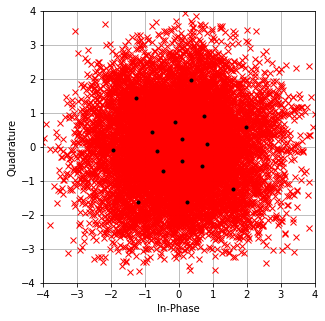

In [109]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, aspect='equal')

N = 1000
EbNo1 = 10.0**(SNR/10.0)
noise_std1 = np.sqrt(1/(2*EbNo1))
for i in range(len(constellation)):
    absol = np.sqrt(np.sum(np.square(constellation[i])))
    var = beta*np.square(absol)+np.square(noise_std1)
    w = np.random.randn(N,2)*np.sqrt(var);
    plt.plot(constellation[i,0]+w[:,0],constellation[i,1]+w[:,1],'rx')

plt.plot(constellation[:,0], constellation[:,1], 'k.')
plt.grid(True)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
#plt.title('Learned Constellation (%d) (NonLin Gaussian)' %M)
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.savefig('16QAMnon015.eps',format='eps')
plt.show()

In [47]:
# calculating BER (Autoencoder)
EbNodB_range = list(np.arange(0,13.5,0.5))
ber = [None]*len(EbNodB_range)
for i in range(0, len(EbNodB_range)):
    EbNo = 10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*EbNo))
    no_err = 0
    no_err1 = 0
    
    encoded_signal = encoder.predict(test_data)
    noise = nonlin_Gaussian(encoded_signal,noise_std)
    noise_signal = encoded_signal + noise
    final_signal = decoder.predict(noise_signal)
    pred_out = np.argmax(final_signal, axis = 1)
    
    no_err = (pred_out != test_label)
    no_err = no_err.astype(int).sum()
    ber[i] = no_err / (N_test*k)
    print(ber[i],',')
    

0.156455 ,
0.151505 ,
0.14662 ,
0.13948 ,
0.13342 ,
0.127255 ,
0.12056 ,
0.11294 ,
0.106235 ,
0.099065 ,
0.092365 ,
0.08469 ,
0.07818 ,
0.071685 ,
0.063875 ,
0.05781 ,
0.051405 ,
0.045435 ,
0.04021 ,
0.03512 ,
0.03015 ,
0.02644 ,
0.02256 ,
0.01924 ,
0.016195 ,
0.013455 ,
0.011735 ,


In [48]:
# 16 QAM BER (Nonlin Gaussian)
ber_c = [None]*len(EbNodB_range)

alpha16qam = np.array([-3, -1, 1, 3,])
ipHat = np.zeros([1,N_test])

for i in range(0, len(EbNodB_range)):
    ip = np.random.choice(alpha16qam, N_test) + 1j*np.random.choice(alpha16qam, N_test)
    
    s = np.zeros([N_test,2])
    for j in range(len(ip)):
        s[j][0] = ip[j].real
        s[j][1] = ip[j].imag
    s = (1/np.sqrt(10))*s
    no_err = 0
    
    EbNo = 10.0**(EbNodB_range[i]/10.0)
    noise_std = np.sqrt(1/(2*k*EbNo))
    noise = nonlin_Gaussian(s,noise_std)
    y = s + noise
    y = y.view(np.complex128).flatten()
    
    y_re = y.real
    y_im = y.imag
    
    ipHat_re = np.zeros(y_re.shape)
    ipHat_im = np.zeros(y_im.shape)
    

    ipHat_re[np.where(y_re < -2/np.sqrt(10))]           = -3
    ipHat_re[np.where(y_re > 2/np.sqrt(10))]            =  3
    ipHat_re[np.where((y_re>-2/np.sqrt(10)) & (y_re<=0))]  = -1
    ipHat_re[np.where((y_re>0) & (y_re<=2/np.sqrt(10)))]   =  1

    ipHat_im[np.where(y_im< -2/np.sqrt(10))]           = -3
    ipHat_im[np.where(y_im > 2/np.sqrt(10))]           =  3
    ipHat_im[np.where((y_im>-2/np.sqrt(10)) & (y_im<=0))]  = -1
    ipHat_im[np.where((y_im>0) & (y_im<=2/np.sqrt(10)))]  =  1
    ipHat = ipHat_re + 1j*ipHat_im
    
    no_err = (ipHat != ip) 
    no_err = no_err.astype(int).sum()
    ber_c[i] = no_err / (N_test*k)
    print(ber_c[i],',')

0.12471 ,
0.117265 ,
0.11084 ,
0.10402 ,
0.09622 ,
0.0888 ,
0.08086 ,
0.072865 ,
0.06533 ,
0.059945 ,
0.052995 ,
0.046845 ,
0.04066 ,
0.035805 ,
0.0308 ,
0.02642 ,
0.02217 ,
0.019145 ,
0.01678 ,
0.013725 ,
0.01191 ,
0.0098 ,
0.00883 ,
0.00727 ,
0.00661 ,
0.0056 ,
0.005005 ,


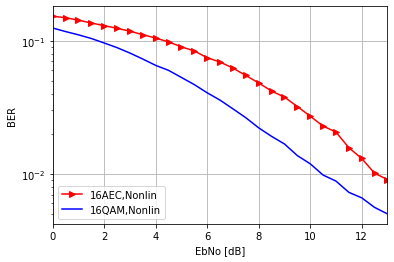

In [51]:
fig, ax = plt.subplots()
ax.plot(EbNodB_range,ber, 'r->', label = '%dAEC,Nonlin' %M)
ax.plot(EbNodB_range,ber_c, 'b-', label = '%dQAM,Nonlin' %M)
#plt.title('%dQAM Non-Linear' %M)
plt.yscale('log')
plt.xlim([0,13])
#plt.xlim([0,17])
plt.xlabel('EbNo [dB]')
plt.ylabel('BER')
plt.grid()
legend = ax.legend(loc = 'lower left', ncol = 1)
#plt.savefig('16QAMnontest.png')
plt.show()

In [50]:
ber = [0.152845,
 0.14899,
 0.142765,
 0.13597,
 0.129935,
 0.124095,
 0.11808,
 0.111025,
 0.104855,
 0.097995,
 0.09001,
 0.08388,
 0.07455,
 0.069205,
 0.062345,
 0.05485,
 0.04824,
 0.04189,
 0.03777,
 0.032065,
 0.027155,
 0.022855,
 0.020625,
 0.01573,
 0.013065,
 0.010115,
 0.009065]